In [1]:
from environment import Environment
from models.baseline import BaselineModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data/train_preprocessed.csv')
test_data = pd.read_csv('data/validate_preprocessed.csv')

In [19]:
def print_func(battery, prices, actions, rewards, revenues):
    '''for i in range(100):
        print('t=%d, battery=%.2f, price=%.2f, action=%d, rewards=%.2f, revenue=%.2f'%(i, battery[i], prices[i], actions[i], rewards[i], revenues[i]))
    '''
    
    print('total reward = ', sum(rewards))
    print('total revenue = ', sum(revenues))
    
    for i in range(len(battery)):
        if actions[i]!=25:
            hour = i%24
            print('t=%d, hour=%d, battery=%.2f, price=%.2f, action=%d, rewards=%.2f, revenue=%.2f'%(i, hour, battery[i], prices[i], actions[i], rewards[i], revenues[i]))

    return

def plot_func(battery, prices, actions, rewards, revenues):
    x = range(len(battery))
    
    '''print(battery)
    print(prices)
    print(actions)
    print(rewards)
    '''
    plt.scatter(x, battery)
    plt.title('Battery')
    plt.show()
    
    plt.scatter(x, prices)
    plt.title('Prices')
    plt.show()
    
    plt.scatter(x, actions)
    plt.title('Actions')
    plt.show()
    
    
    plt.scatter(x, rewards)
    plt.title('Rewards')
    plt.show()
    
    rewards = np.array(rewards)
    plt.scatter(x, np.cumsum(rewards))
    plt.title('Cumulative rewards')
    plt.show()
    
    '''plt.scatter(x, revenues)
    plt.title('Revenues')
    plt.show()'''
    
    
    return

In [20]:
def learn(env, model, t_max):
    rewards, battery, revenues, actions, prices = [], [], [], [], []
    i=0
    obs, reward = env.reset(data)
    
    while i<t_max:
        action = model.predict(data, obs)
        battery.append(obs['battery'])
        prices.append(obs['price'])
        
        obs, reward = env.step(action, data)
        
        actions.append(action)
        rewards.append(reward)
        
        if action < 25: #sell
            revenue = -(action-25)*prices[-1]
        elif action > 25: #buy
            revenue = -2*(action-25)*prices[-1] #obs['price']
        else:
            revenue = 0
        revenues.append(revenue)

        i+=1
    
    print_func(battery, prices, actions, rewards, revenues)
    plot_func(battery, prices, actions, rewards, revenues)
    
    return

total reward =  -1793.6472222222221
total revenue =  -2253.35
t=0, hour=0, battery=20.00, price=24.31, action=50, rewards=-795.00, revenue=-1215.50
t=1, hour=1, battery=45.00, price=24.31, action=30, rewards=-159.00, revenue=-243.10
t=42, hour=18, battery=50.00, price=59.69, action=0, rewards=1118.02, revenue=1492.25
t=45, hour=21, battery=25.00, price=36.22, action=50, rewards=-1456.67, revenue=-1811.00
t=66, hour=18, battery=50.00, price=60.99, action=0, rewards=1147.28, revenue=1524.75
t=69, hour=21, battery=25.00, price=34.51, action=50, rewards=-1361.67, revenue=-1725.50
t=90, hour=18, battery=50.00, price=58.99, action=0, rewards=1102.28, revenue=1474.75
t=93, hour=21, battery=25.00, price=35.00, action=50, rewards=-1388.89, revenue=-1750.00


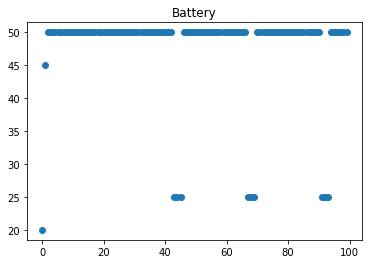

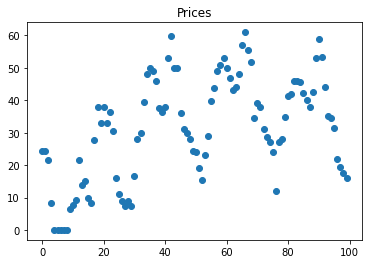

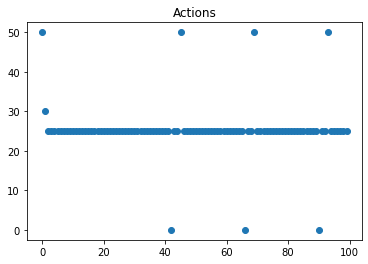

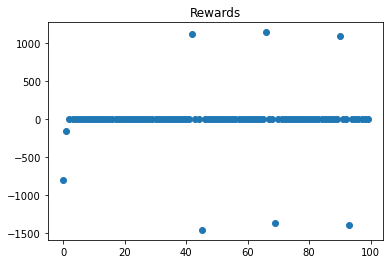

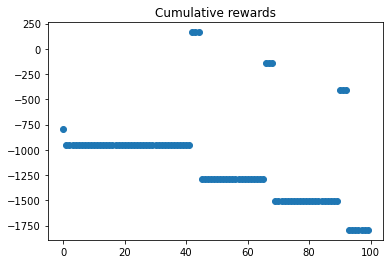

In [21]:
env = Environment(data)
model = BaselineModel(test_data)
t_max = 100

learn(env, model, t_max)